In [1]:
from pprint import pprint
import time
import requests
import pandas as pd
from config import rapidapi_key
#from datetime import datetime
import matplotlib.pyplot as plt
import datetime
import math
import numpy as np

## Italy Index

In [2]:
italy_df = pd.read_csv("italy_index/FTSE Italia All Share Historical Data.csv")

In [3]:
italy_df

,Date,Price,Open,High,Low,Vol.,Change %,Timestamp
0,2020-3-20,17171.55,17209.93,17628.87,17047.73,1500000000,1.85,1584662400
1,2020-3-19,16859.82,16814.38,17240.13,16438.49,1270000000,2.27,1584576000
2,2020-3-18,16486.21,16372.27,16785.57,16149.48,992760000,-1.17,1584489600
3,2020-3-17,16680.56,16850.34,17238.59,16065.72,1400000000,1.96,1584403200
4,2020-3-16,16360.04,17130.96,17130.96,15498.19,1540000000,-6.06,1584316800
...,...,...,...,...,...,...,...,...
321,2018-12-7,20597.68,20650.69,20818.51,20597.68,616630000,0.49,1544140800
322,2018-12-6,20496.44,21014.83,21014.83,20433.79,1090000000,-3.38,1544054400
323,2018-12-5,21213.03,21041.15,21287.70,20990.68,691120000,-0.19,1543968000
324,2018-12-4,21254.03,21494.44,21517.80,21254.03,961020000,-1.26,1543881600


In [4]:

volatile_yr_avg = []
yearlyGroups = []
yearlyTimestamp = []
for i in range(0,len(italy_df['Timestamp'])):
    try:
        cond1 = italy_df['Timestamp']<=italy_df['Timestamp'][i]
        cond2 = (pd.Series(italy_df['Timestamp']>=(italy_df['Timestamp'][i]-(365*24*60*60))))
        df = italy_df[cond1 & cond2]
        #print('working')
        if len(df)>251:  #avoids sets less than a full year
            volatile_yr_avg.append(df.std()['Change %']*math.sqrt(252)) #annual volatility (stdev * sqrt(252))
            yearlyGroups.append(italy_df['Date'][i])
            yearlyTimestamp.append(italy_df['Timestamp'][i])
    except:
        print('Error Found')
volatile_italy_dict = {"Date":yearlyGroups,
                    "Annual Volatility":volatile_yr_avg,
                       "Timestamp":yearlyTimestamp
                    }
volatile_italy_df = pd.DataFrame(volatile_italy_dict)
volatile_italy_df['Date']=pd.to_datetime(volatile_italy_df['Date'])
volatile_italy_df.head()

,Date,Annual Volatility,Timestamp
0,2020-03-20,27.592528,1584662400
1,2020-03-19,27.525696,1584576000
2,2020-03-18,27.440077,1584489600
3,2020-03-17,27.435507,1584403200
4,2020-03-16,27.411226,1584316800


C:\Users\chand\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


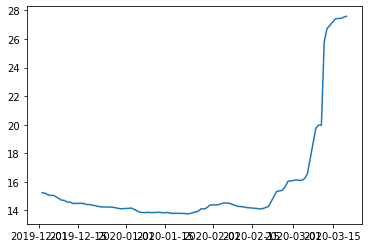

In [5]:
plt.plot(volatile_italy_df['Date'],volatile_italy_df['Annual Volatility'])
#volatile_italy_df.plot('Date','Annual Volatility',kind = 'scatter')

## S&P 500

In [6]:
curr_time = int(time.time())
#prior_year = curr_time-(60*60*24*365)
prior_year = 1543622400  # unix for December 01,2018
ticker_symbol = "^GSPC"

In [7]:
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapidapi_key
    }

response = requests.request("GET", url, headers=headers, params=querystring)


In [8]:
timestamp = response.json()['chart']['result'][0]['timestamp']
year_close = response.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

smpDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
smp_df = pd.DataFrame(smpDict)
smp_df['Change %'] = (smp_df['Close']-smp_df['Open'])/smp_df['Open']

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(smp_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(smp_df['Timestamp']))]
smp_df['Date'] = convert_date


smp_df['Last Year'] =[datetime.datetime.strptime(smp_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(smp_df['Date']))]




smp_df.shape

(329, 8)

In [9]:
volatile_yr_avg = []
yearlyGroups = []
yearlyTimestamp = []
for i in range(0,len(smp_df['Timestamp'])):
    try:
        cond1 = smp_df['Timestamp']<=smp_df['Timestamp'][i]
        cond2 = (pd.Series(smp_df['Timestamp']>=(smp_df['Timestamp'][i]-(365*24*60*60))))
        df = smp_df[cond1 & cond2]
        #print('working')
        if len(df)>251:  #avoids sets less than a full year
            volatile_yr_avg.append(df.std()['Change %']*math.sqrt(len(df))*100) #annual volatility (stdev * sqrt(252))
            yearlyGroups.append(smp_df['Date'][i]) 
            yearlyTimestamp.append(smp_df['Timestamp'][i])
    except:
        print('Error Found')
volatile_smp_dict = {"Date":yearlyGroups,
                    "Annual Volatility":volatile_yr_avg,
                     "Timestamp":yearlyTimestamp
                    }
volatile_smp_df = pd.DataFrame(volatile_smp_dict)
volatile_smp_df['Date']=pd.to_datetime(volatile_smp_df['Date'])
volatile_smp_df.head()

,Date,Annual Volatility,Timestamp
0,2019-12-03,11.981884,1575383400
1,2019-12-04,11.985080,1575469800
2,2019-12-05,11.605491,1575556200
3,2019-12-06,11.610007,1575642600
4,2019-12-09,11.339866,1575901800


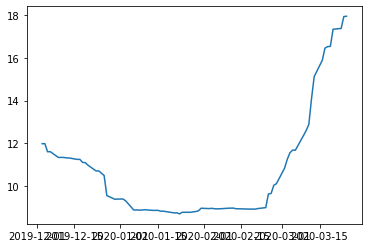

In [10]:
plt.plot(volatile_smp_df['Date'],volatile_smp_df['Annual Volatility'])


#volatile_smp_df.plot('Timestamp','Annual Volatility',kind = 'scatter')

## SSE Composite Index

In [11]:
curr_time = int(time.time())
#prior_year = curr_time-(60*60*24*365)
prior_year = 1543622400  # unix for December 01,2018

ticker_symbol = "000001.SS"

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapidapi_key
    }

response2 = requests.request("GET", url, headers=headers, params=querystring)


In [12]:
timestamp = response2.json()['chart']['result'][0]['timestamp']
year_close = response2.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response2.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response2.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response2.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

sseDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
sse_df = pd.DataFrame(sseDict)

sse_df['Change %'] = (sse_df['Close']-sse_df['Open'])/sse_df['Open']

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(sse_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(sse_df['Timestamp']))]
sse_df['Date'] = convert_date

sse_df['Last Year'] =[datetime.datetime.strptime(sse_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(sse_df['Date']))]
sse_df.head()



,Timestamp,Open,Close,Volume,Adjclose,Change %,Date,Last Year
0,1543800600,2647.132080,2654.798096,207500.0,2654.798096,0.002896,2018-12-03,2017-12-03
1,1543887000,2651.561035,2665.958008,167900.0,2665.958008,0.005430,2018-12-04,2017-12-04
2,1543973400,2629.833008,2649.804932,154500.0,2649.804932,0.007594,2018-12-05,2017-12-05
3,1544059800,2629.820068,2605.180908,141700.0,2605.180908,-0.009369,2018-12-06,2017-12-06
4,1544146200,2609.341064,2605.887939,109100.0,2605.887939,-0.001323,2018-12-07,2017-12-07


In [13]:
len(sse_df)

316

In [14]:
volatile_yr_avg = []
yearlyGroups = []
yearlyTimestamp = []
df_len_check = []
for i in range(0,len(sse_df['Timestamp'])):
    try:
        cond1 = sse_df['Timestamp']<=sse_df['Timestamp'][i]
        cond2 = (pd.Series(sse_df['Timestamp']>=(sse_df['Timestamp'][i]-(365*24*60*60))))
        df = sse_df[cond1 & cond2]
        #print('working')
        if len(df)>239:  #avoids sets less than a full year
            volatile_yr_avg.append(df.std()['Change %']*math.sqrt(len(df))*100) #annual volatility (stdev * sqrt(252))
            yearlyGroups.append(sse_df['Date'][i]) 
            yearlyTimestamp.append(sse_df['Timestamp'][i])
            df_len_check.append(len(df))
    except:
        print('Error Found')
volatile_sse_dict = {"Date":yearlyGroups,
                    "Annual Volatility":volatile_yr_avg,
                     "Timestamp":yearlyTimestamp
                    }
volatile_sse_df = pd.DataFrame(volatile_sse_dict)
volatile_sse_df['Date']=pd.to_datetime(volatile_sse_df['Date'])
volatile_sse_df.head()

,Date,Annual Volatility,Timestamp
0,2019-11-29,14.948930,1574991000
1,2019-12-02,14.948811,1575250200
2,2019-12-03,14.955485,1575336600
3,2019-12-04,14.953838,1575423000
4,2019-12-05,14.951118,1575509400


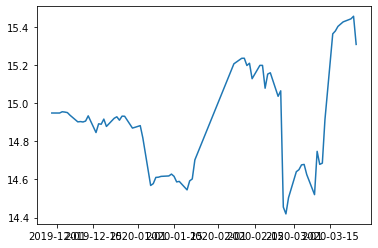

In [15]:
plt.plot(volatile_sse_df['Date'],volatile_sse_df['Annual Volatility'])


#volatile_sse_df.plot('Timestamp','Annual Volatility',kind = 'scatter')

## Dow Jones Industrial Average 

In [16]:
curr_time = int(time.time())
#prior_year = curr_time-(60*60*24*365)
prior_year = 1543622400  # unix for December 01,2018

ticker_symbol = "^DJI"

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapidapi_key
    }

response3 = requests.request("GET", url, headers=headers, params=querystring)


In [17]:
timestamp = response3.json()['chart']['result'][0]['timestamp']
year_close = response3.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response3.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response3.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response3.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

djiDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
dji_df = pd.DataFrame(djiDict)
dji_df['Change %'] = (dji_df['Close']-dji_df['Open'])/dji_df['Open']

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(dji_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(dji_df['Timestamp']))]
dji_df['Date'] = convert_date

dji_df['Last Year'] =[datetime.datetime.strptime(dji_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(dji_df['Date']))]
dji_df.head()


,Timestamp,Open,Close,Volume,Adjclose,Change %,Date,Last Year
0,1543847400,25779.570312,25826.429688,388480000,25826.429688,0.001818,2018-12-03,2017-12-03
1,1543933800,25752.560547,25027.070312,418900000,25027.070312,-0.028172,2018-12-04,2017-12-04
2,1544106600,24737.419922,24947.669922,471690000,24947.669922,0.008499,2018-12-06,2017-12-06
3,1544193000,24918.820312,24388.949219,398230000,24388.949219,-0.021264,2018-12-07,2017-12-07
4,1544452200,24360.949219,24423.259766,389690000,24423.259766,0.002558,2018-12-10,2017-12-10


In [18]:
volatile_yr_avg = []
yearlyGroups = []
yearlyTimestamp = []
for i in range(0,len(dji_df['Timestamp'])):
    try:
        cond1 = dji_df['Timestamp']<=dji_df['Timestamp'][i]
        cond2 = (pd.Series(dji_df['Timestamp']>=(dji_df['Timestamp'][i]-(365*24*60*60))))
        df = dji_df[cond1 & cond2]
        #print('working')
        if len(df)>251:  #avoids sets less than a full year
            volatile_yr_avg.append(df.std()['Change %']*math.sqrt(len(df))*100) #annual volatility (stdev * sqrt(252))
            yearlyGroups.append(dji_df['Date'][i])
            yearlyTimestamp.append(dji_df['Timestamp'][i])
    except:
        print('Error Found')
volatile_dji_dict = {"Date":yearlyGroups,
                    "Annual Volatility":volatile_yr_avg,
                     "Timestamp":yearlyTimestamp
                    }
volatile_dji_df = pd.DataFrame(volatile_dji_dict)
volatile_dji_df['Date']=pd.to_datetime(volatile_dji_df['Date'])
volatile_dji_df.head()

,Date,Annual Volatility,Timestamp
0,2019-12-03,12.314809,1575383400
1,2019-12-04,12.313758,1575469800
2,2019-12-05,11.982959,1575556200
3,2019-12-06,11.998031,1575642600
4,2019-12-09,11.777236,1575901800


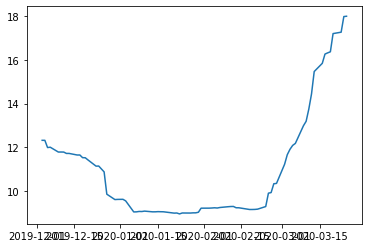

In [19]:
plt.plot(volatile_dji_df['Date'],volatile_dji_df['Annual Volatility'])


#volatile_italy_df.plot('Timestamp','Annual Volatility',kind = 'scatter')

## Covid19 Data

In [20]:
time_series_2019_ncov_Deaths =pd.read_csv("covid19_data/time_series_2019-ncov-Deaths.csv")
time_series_2019_ncov_Recovered = pd.read_csv("covid19_data/time_series_2019-ncov-Recovered.csv")
time_series_ncov_Confirmed = pd.read_csv("covid19_data/time_series-ncov-Confirmed.csv")
time_series_ncov_Deaths = pd.read_csv("covid19_data/time_series-ncov-Deaths.csv")
time_series_2019_ncov_Confirmed = pd.read_csv("covid19_data/time_series_2019-ncov-Confirmed.csv")
time_series_ncov_Recovered = pd.read_csv("covid19_data/time_series-ncov-Recovered.csv")




## Deaths

### US

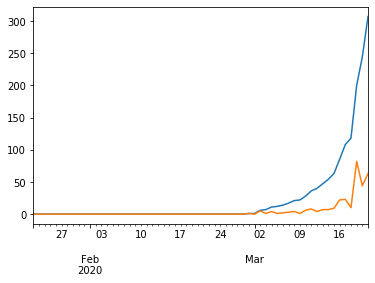

In [21]:
us_cond=time_series_2019_ncov_Deaths['Country/Region']=='US'

us_deaths = time_series_2019_ncov_Deaths[us_cond]
us_deaths =us_deaths.drop(columns =['Lat','Long','Province/State'])
us_deaths = us_deaths.groupby('Country/Region').sum()

us_deaths =us_deaths.T
us_deaths.index = pd.to_datetime(us_deaths.index)
#us_deaths.plot(legend=False)

us_daily = [0]
for i in range(1,len(us_deaths['US'])):
    us_daily.append(us_deaths['US'][i]-us_deaths['US'][i-1])
us_daily_df = us_deaths[['US']]
us_daily_df['Daily']=us_daily

us_daily_df.plot(legend=False)
plt.show()

us_daily = [0]
us_daily_percent = [0]
for i in range(1,len(us_recovered['US'])):
    
    us_daily.append(us_recovered['US'][i]-us_recovered['US'][i-1])
    if us_recovered['US'][i-1]>0:
        us_daily_percent.append((us_recovered['US'][i]-us_recovered['US'][i-1])/us_recovered['US'][i-1])
    else:
        us_daily_percent.append(0)
us_daily_df = us_recovered[['US']]
us_daily_df['Daily']=us_daily
us_daily_df['Percent Change'] = us_daily_percent

#us_daily_df.plot(legend=False)
us_daily_df['Percent Change'].plot(legend=True)

### Italy

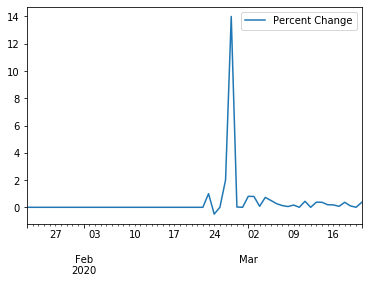

In [50]:
italy_cond=time_series_2019_ncov_Deaths['Country/Region']=='Italy'

italy_deaths = time_series_2019_ncov_Deaths[italy_cond]
italy_deaths =italy_deaths.drop(columns =['Lat','Long','Province/State'])
italy_deaths = italy_deaths.groupby('Country/Region').sum()

italy_deaths =italy_deaths.T
italy_deaths.index = pd.to_datetime(italy_deaths.index)

italy_daily = [0]
italy_daily_percent = [0]
for i in range(1,len(italy_deaths['Italy'])):
    italy_daily.append(italy_deaths['Italy'][i]-italy_deaths['Italy'][i-1])
    
    if italy_recovered['Italy'][i-1]>0:
        italy_daily_percent.append((italy_recovered['Italy'][i]-italy_recovered['Italy'][i-1])/italy_recovered['Italy'][i-1])
    else:
        italy_daily_percent.append(0)    
    
italy_daily_df = italy_deaths[['Italy']]
italy_daily_df['Daily']=italy_daily
italy_daily_df['Percent Change'] = italy_daily_percent

#italy_daily_df.plot(legend=False)
italy_daily_df['Percent Change'].plot(legend=True)
plt.show()


### China

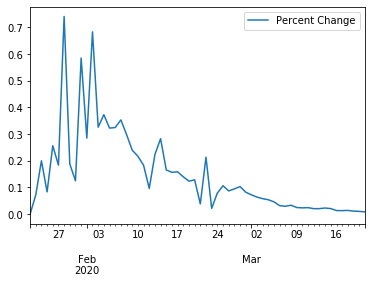

In [48]:
china_cond=time_series_2019_ncov_Deaths['Country/Region']=='China'

china_deaths = time_series_2019_ncov_Deaths[china_cond]
china_deaths =china_deaths.drop(columns =['Lat','Long','Province/State'])
china_deaths = china_deaths.groupby('Country/Region').sum()

china_deaths =china_deaths.T
china_deaths.index = pd.to_datetime(china_deaths.index)
#china_deaths.plot(legend=False)

china_daily = [0]
china_daily_percent = [0]
for i in range(1,len(china_deaths['China'])):
    china_daily.append(china_deaths['China'][i]-china_deaths['China'][i-1])
    if china_recovered['China'][i-1]>0:
        china_daily_percent.append((china_recovered['China'][i]-china_recovered['China'][i-1])/china_recovered['China'][i-1])
    else:
        china_daily_percent.append(0)    
    
    
china_daily_df = china_deaths[['China']]
china_daily_df['Daily']=china_daily
china_daily_df['Percent Change'] = china_daily_percent

#china_daily_df.plot(legend=False)
china_daily_df['Percent Change'].plot(legend=True)

plt.show()


## Number of Recovered

### US

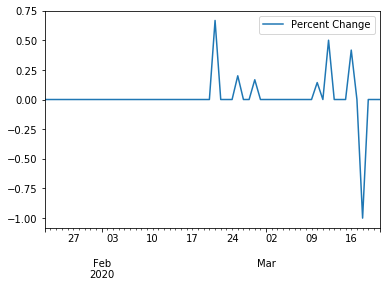

In [46]:
us_cond=time_series_2019_ncov_Recovered['Country/Region']=='US'

us_recovered = time_series_2019_ncov_Recovered[us_cond]
us_recovered =us_recovered.drop(columns =['Lat','Long','Province/State'])
us_recovered = us_recovered.groupby('Country/Region').sum()

us_recovered =us_recovered.T
us_recovered.index = pd.to_datetime(us_recovered.index)
#us_recovered.plot(legend=False)

us_daily = [0]
us_daily_percent = [0]
for i in range(1,len(us_recovered['US'])):
    
    us_daily.append(us_recovered['US'][i]-us_recovered['US'][i-1])
    if us_recovered['US'][i-1]>0:
        us_daily_percent.append((us_recovered['US'][i]-us_recovered['US'][i-1])/us_recovered['US'][i-1])
    else:
        us_daily_percent.append(0)
us_daily_df = us_recovered[['US']]
us_daily_df['Daily']=us_daily
us_daily_df['Percent Change'] = us_daily_percent

#us_daily_df.plot(legend=False)
us_daily_df['Percent Change'].plot(legend=True)
plt.show()

### Italy

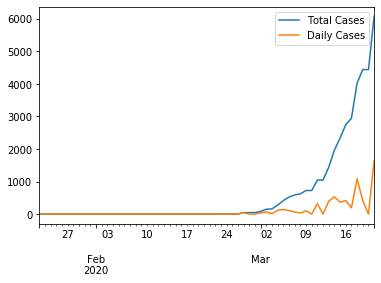

In [25]:
italy_cond=time_series_2019_ncov_Recovered['Country/Region']=='Italy'

italy_recovered = time_series_2019_ncov_Recovered[italy_cond]
italy_recovered =italy_recovered.drop(columns =['Lat','Long','Province/State'])
italy_recovered = italy_recovered.groupby('Country/Region').sum()

italy_recovered =italy_recovered.T
italy_recovered.index = pd.to_datetime(italy_recovered.index)
#italy_recovered.plot(legend=False)

italy_daily = [0]
for i in range(1,len(italy_recovered['Italy'])):
    italy_daily.append(italy_recovered['Italy'][i]-italy_recovered['Italy'][i-1])
italy_daily_df = italy_recovered[['Italy']]
italy_daily_df['Daily']=italy_daily
italy_daily_df.columns = ["Total Cases","Daily Cases"]
italy_daily_df.plot(legend=False)
plt.legend()
plt.show()

### China

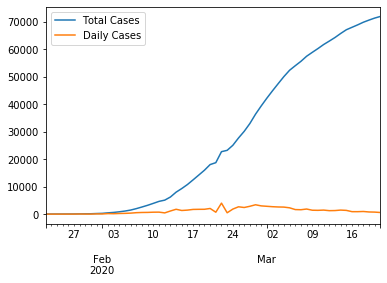

In [26]:
china_cond=time_series_2019_ncov_Recovered['Country/Region']=='China'

china_recovered = time_series_2019_ncov_Recovered[china_cond]
china_recovered =china_recovered.drop(columns =['Lat','Long','Province/State'])
china_recovered = china_recovered.groupby('Country/Region').sum()

china_recovered =china_recovered.T
china_recovered.index = pd.to_datetime(china_recovered.index)
#china_recovered.plot(legend=False)

china_daily = [0]
for i in range(1,len(china_recovered['China'])):
    china_daily.append(china_recovered['China'][i]-china_recovered['China'][i-1])
china_daily_df = china_recovered[['China']]
china_daily_df['Daily']=china_daily
china_daily_df.columns=['Total Cases','Daily Cases']
china_daily_df.plot(legend=False)
plt.legend()
plt.show()

# Number Confirmed Cases

### US

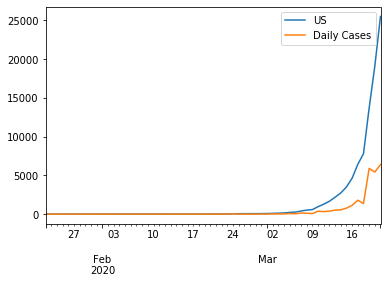

In [27]:
us_cond=time_series_2019_ncov_Confirmed['Country/Region']=='US'

us_confirmed = time_series_2019_ncov_Confirmed[us_cond]
us_confirmed =us_confirmed.drop(columns =['Lat','Long','Province/State'])
us_confirmed = us_confirmed.groupby('Country/Region').sum()

us_confirmed =us_confirmed.T
us_confirmed.index = pd.to_datetime(us_confirmed.index)
us_confirmed.plot(legend=True,label = "Total Cases")

us_daily = [0]
for i in range(1,len(us_confirmed['US'])):
    us_daily.append(us_confirmed['US'][i]-us_confirmed['US'][i-1])
us_daily_df = us_confirmed[['US']]
us_daily_df['Daily']=us_daily

us_daily_plot = us_daily_df['Daily']
us_daily_plot.plot(legend=False,label = "Daily Cases")
plt.legend()
plt.show()

### Italy

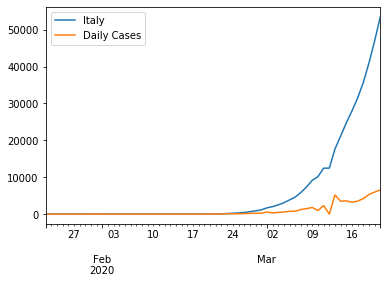

In [28]:
italy_cond=time_series_2019_ncov_Confirmed['Country/Region']=='Italy'

italy_confirmed = time_series_2019_ncov_Confirmed[italy_cond]
italy_confirmed =italy_confirmed.drop(columns =['Lat','Long','Province/State'])
italy_confirmed = italy_confirmed.groupby('Country/Region').sum()

italy_confirmed =italy_confirmed.T
italy_confirmed.index = pd.to_datetime(italy_confirmed.index)
italy_confirmed.plot(legend=False)

italy_daily = [0]
for i in range(1,len(italy_confirmed['Italy'])):
    italy_daily.append(italy_confirmed['Italy'][i]-italy_confirmed['Italy'][i-1])
italy_daily_df = italy_confirmed[['Italy']]
italy_daily_df['Daily']=italy_daily
italy_daily_plot=italy_daily_df['Daily']

italy_daily_plot.plot(legend=False, label = 'Daily Cases')
plt.legend()
plt.show()

### China

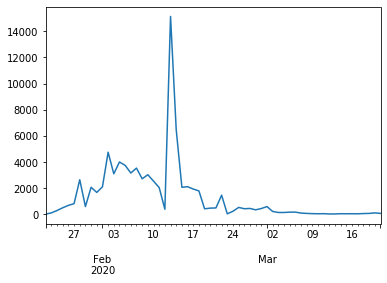

In [29]:
china_cond=time_series_2019_ncov_Confirmed['Country/Region']=='China'

china_confirmed = time_series_2019_ncov_Confirmed[china_cond]
china_confirmed =china_confirmed.drop(columns =['Lat','Long','Province/State'])
china_confirmed = china_confirmed.groupby('Country/Region').sum()

china_confirmed =china_confirmed.T
china_confirmed.index = pd.to_datetime(china_confirmed.index)
#china_confirmed.plot(legend=False)

china_daily = [0]
for i in range(1,len(china_confirmed['China'])):
    china_daily.append(china_confirmed['China'][i]-china_confirmed['China'][i-1])
china_daily_df = china_confirmed[['China']]
china_daily_df['Daily']=china_daily
china_daily_plot = china_daily_df['Daily']
china_daily_plot.plot(legend=False)

plt.show()

### Unorganized data?

In [30]:
time_series_ncov_Confirmed.head()

#t = time_series_ncov_Confirmed
#t =t.drop(columns =['Lat','Long','Province/State'])
#t =t.set_index('Country/Region')
#t =t.T
#t.plot(legend=False)
#plt.show()

,Province/State,Country/Region,Lat,Long,Date,Value
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+infected+value+num
1,NaN,Afghanistan,33,65,2020-03-21,24
2,NaN,Afghanistan,33,65,2020-03-20,24
3,NaN,Afghanistan,33,65,2020-03-19,22
4,NaN,Afghanistan,33,65,2020-03-18,22


In [31]:
time_series_ncov_Deaths.head()

#t = time_series_ncov_Deaths
#t =t.drop(columns =['Lat','Long','Province/State'])
#t =t.set_index('Country/Region')
#t =t.T
#t.plot(legend=False)
#plt.show()

,Province/State,Country/Region,Lat,Long,Date,Value
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+killed+value+num
1,NaN,Afghanistan,33,65,2020-03-21,0
2,NaN,Afghanistan,33,65,2020-03-20,0
3,NaN,Afghanistan,33,65,2020-03-19,0
4,NaN,Afghanistan,33,65,2020-03-18,0


In [32]:
time_series_ncov_Recovered.head()

,Province/State,Country/Region,Lat,Long,Date,Value
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+recovered+value+num
1,NaN,Afghanistan,33,65,2020-03-21,1
2,NaN,Afghanistan,33,65,2020-03-20,1
3,NaN,Afghanistan,33,65,2020-03-19,1
4,NaN,Afghanistan,33,65,2020-03-18,1


## Test comparisons

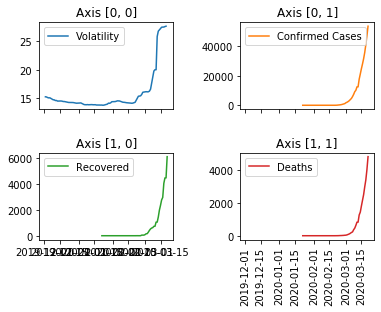

In [33]:
fig, axs = plt.subplots(2,2, sharex = True, sharey = False, gridspec_kw ={'hspace':0.5,'wspace':.5})
axs[0, 0].plot(volatile_italy_df['Date'],volatile_italy_df['Annual Volatility'],  label = "Volatility")
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].legend()

axs[0, 1].plot(italy_confirmed['Italy'],label='Confirmed Cases', color= 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[0, 1].legend()

axs[1, 0].plot(italy_recovered['Italy'],label = 'Recovered', color ='tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 0].legend()

axs[1, 1].plot(italy_deaths['Italy'],label = 'Deaths', color ='tab:red')
axs[1, 1].set_title('Axis [1, 1]')
axs[1, 1].legend()
plt.xticks(rotation=90)

for ax in axs.flat:
    
    plt.xticks(rotation=90)

#axes[0].plot(volatile_italy_df['Date'],volatile_italy_df['Annual Volatility'],  label = "Volatility")
#axes[1].plot(italy_confirmed['Italy'],label='Confirmed Cases')
#axes[2].plot(italy_recovered['Italy'],label = 'Recovered')
#axes[3].plot(italy_deaths['Italy'],label = 'Deaths')
#plt.yscale('symlog')
#plt.legend()
plt.show()

#https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

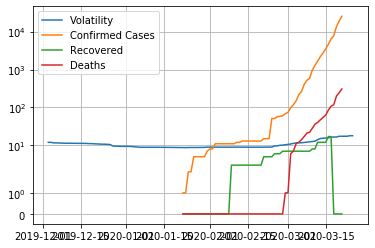

In [34]:
plt.plot(volatile_smp_df['Date'],volatile_smp_df['Annual Volatility'], label = "Volatility")
plt.plot(us_confirmed['US'], label = "Confirmed Cases")
plt.plot(us_recovered['US'],label = "Recovered")
plt.plot(us_deaths['US'], label ="Deaths")
plt.yscale('symlog')
plt.legend()
plt.grid()
plt.show()

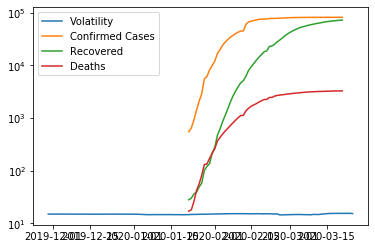

In [35]:
plt.plot(volatile_sse_df['Date'],volatile_sse_df['Annual Volatility'],label = "Volatility")
plt.plot(china_confirmed['China'], label = "Confirmed Cases")
plt.plot(china_recovered['China'],label = "Recovered")
plt.plot(china_deaths['China'],label = "Deaths")
plt.legend()
plt.yscale('symlog')
plt.show()

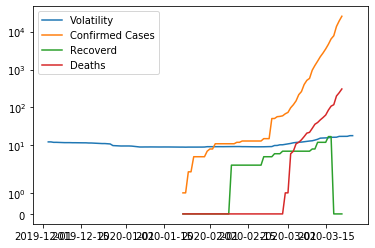

In [36]:

plt.plot(volatile_dji_df['Date'],volatile_dji_df['Annual Volatility'], label = "Volatility")
plt.plot(us_confirmed['US'], label = "Confirmed Cases")
plt.plot(us_recovered['US'], label = "Recoverd")
plt.plot(us_deaths['US'], label = "Deaths")
plt.yscale('symlog')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'twinx'

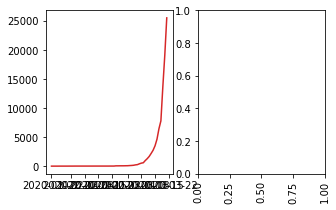

In [37]:
fig, ax1 = plt.subplots(nrows=1,ncols=2,figsize=(5,3))
ax1[0].plot(us_confirmed['US'], color ='tab:red')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
ax2.plot(volatile_dji_df['Date'],volatile_dji_df['Annual Volatility'])




In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of People')
ax1.plot(us_confirmed['US'], label = "Confirmed Cases")
ax1.plot(us_recovered['US'], label = "Recoverd")
ax1.plot(us_deaths['US'], label = "Deaths")
plt.yscale('symlog')
plt.legend()
ax1 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Annual Volatility %')
ax2.plot(volatile_dji_df['Annual Volatility'], label = "Volatility")


#plt.plot(volatile_dji_df['Date'],volatile_dji_df['Annual Volatility'], label = "Volatility")
#plt.plot(us_confirmed['US'], label = "Confirmed Cases")
#plt.plot(us_recovered['US'], label = "Recoverd")
#plt.plot(us_deaths['US'], label = "Deaths")
#plt.yscale('symlog')
#plt.legend()
plt.show()